In [50]:
import json

import os

import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec



In [51]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

# plt.rcParams['text.usetex'] = True


plt.rcParams['savefig.format'] = 'pdf'

# savefig_loc = "imgs/test/"
savefig_loc = "imgs/attackvectors/test/"

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.set_context('notebook')
sns.set_style("ticks")

In [52]:
save_to_file = True
# save_to_file = False


# dataset = 'MNIST'
dataset = 'CIFAR'

if 'MNIST' in dataset:
    _folder_pth = 'datafolder/MNIST/'
else:
    _folder_pth = 'datafolder/CIFAR/'

_folders = os.listdir(_folder_pth)

file_data = {}
models_loaded = []
df_cols = ["epoch", "model", "value_type", "value"]
_df = pd.DataFrame(columns=df_cols)


for _folder in _folders:
    if "exc" not in _folder and os.path.isdir(_folder_pth + _folder):
        models_loaded.append(_folder)
        _folder_contents = os.listdir(_folder_pth + _folder)
        for _file in _folder_contents:
            if _file.endswith(".json"):
                # reading the data from the file
                with open(_folder_pth + _folder + "/"  + _file) as f:
                    _data = json.load(f)

                    file_data[_folder + "_" + _file[:-5]] = _data

                    for idx, val in enumerate([val_l[-1] for val_l in _data]):
                        _df = pd.concat([_df, pd.Series([idx, _folder, _file[:-5], val], index=df_cols)], ignore_index=True, axis=1)
df = _df.copy().transpose().dropna()

In [53]:
print(f"List of attacks found in data: {df.model.unique()}")

List of attacks found in data: ['CW10-0.1' 'CW20-0.1' 'FGSM-NORS' 'FGSM-RS' 'PGD10-0.2' 'PGD5-0.4']


In [54]:
# Cifar styling dict
styledict_cifar = {
    'CW10-0.1' : {"label": "CW$_{0.1}^{10}$"},
    'CW10-0.2' : {"label": "CW$_{0.2}^{10}$"},
    'CW20-0.1'  : {"label": "CW$_{0.1}^{20}$"},

    'FGSM-NORS'  : {"label": "FGSM"},
    'FGSM-RS' : {"label": "FGSM-RS"},
    
    'PGD20-0.1' : {"label": "PGD$_{0.003}^{20}$"},
    'PGD10-0.2' : {"label": "PGD$_{0.006}^{10}$"},
    'PGD10-0.4' : {"label": "PGD$_{0.012}^{10}$"},
    'PGD5-0.4' : {"label": "PGD$_{0.012}^{5}$"},
    'PGD5-0.2' : {"label": "PGD$_{0.006}^{5}$"},
    }

styledict_mnist = {
    'CW10-0.1' : {"label": "CW$_{0.1}^{10}$"},
    'CW10-0.2' : {"label": "CW$_{0.2}^{10}$"},
    'CW20-0.1'  : {"label": "CW$_{0.1}^{20}$"},

    'FGSM-NORS'  : {"label": "FGSM"},
    'FGSM-RS' : {"label": "FGSM-RS"},
    
    'PGD40-0.01' : {"label": "PGD$_{0.01}^{40}$"},
    'PGD20-0.1' : {"label": "PGD$_{0.03}^{20}$"},
    'PGD10-0.2' : {"label": "PGD$_{0.06}^{10}$"},
    'PGD10-0.4' : {"label": "PGD$_{0.12}^{10}$"},
    'PGD5-0.2' : {"label": "PGD$_{0.06}^{5}$"},
    'PGD5-0.4' : {"label": "PGD$_{0.12}^{5}$"},
    }

if 'MNIST' in dataset:
    styledict = styledict_mnist
else:
    styledict = styledict_cifar


In [55]:
import numpy as np

from tqdm import tqdm 

df["label"] = [styledict[modl]["label"] for modl in df['model']]
df["value_inv"] = 1-df["value"]



# print(df.label)

In [56]:
logvals = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    logvals.append(np.log(row["value_inv"]))



100%|██████████| 519/519 [00:00<00:00, 49358.18it/s]


In [57]:
df["val_log"] = logvals

In [58]:
def plot_attack_type_log_acc(data, attack_id, save_file:bool = False):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharey = True)
    titles = ["Adversarial Training accuracy", "Adversarial validation accuracy", "Validation accuracy"]
    for ax_idx, valtype in enumerate(["train_adv_acc", "val_adv_acc", "val_acc"]):
    # for ax_idx, valtype in enumerate(["val_acc", "val_adv_acc"]):
        _ax = axs[ax_idx]
        attacks_included = data.loc[data['model'].str.contains(attack_id)].model.unique()
        
        # _ax.set_ylim(bottom=0, top=1)
        sns.lineplot(x='epoch', y='val_log', data=data.loc[(data["value_type"].isin([valtype])) & data['model'].str.contains(attack_id)], hue='label', ax=_ax)
        l = _ax.legend()
        l.set_title('')
        _ax.set_ylabel("accuracy")
        _ax.grid(visible=True)
        _ax.set_title(f"{titles[ax_idx]}")
        _ax.tick_params(axis='both', which='major', labelleft='True')

    if save_file:
        fig.savefig(savefig_loc + dataset + '_' + attack_id + '_vallog.pdf', dpi=300, format='pdf')

In [59]:
def plot_attack_type(data, attack_id, save_file:bool = False):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharey = True)
    titles = ["Adversarial Training accuracy", "Adversarial validation accuracy", "Validation accuracy"]
    for ax_idx, valtype in enumerate(["train_adv_acc", "val_adv_acc", "val_acc"]):
    # for ax_idx, valtype in enumerate(["val_acc", "val_adv_acc"]):
        _ax = axs[ax_idx]
        attacks_included = data.loc[data['model'].str.contains(attack_id)].model.unique()
        
        _ax.set_ylim(bottom=0, top=1)
        sns.lineplot(x='epoch', y='value', data=data.loc[(data["value_type"].isin([valtype])) & data['model'].str.contains(attack_id)], hue='label', ax=_ax)
        l = _ax.legend()
        l.set_title('')
        _ax.set_ylabel("accuracy")
        _ax.grid(visible=True)
        _ax.set_title(f"{titles[ax_idx]}")
        _ax.tick_params(axis='both', which='major', labelleft='True')

    if save_file:
        fig.savefig(savefig_loc + dataset + '_' + attack_id + '.pdf', dpi=300, format='pdf')
    # return testdata

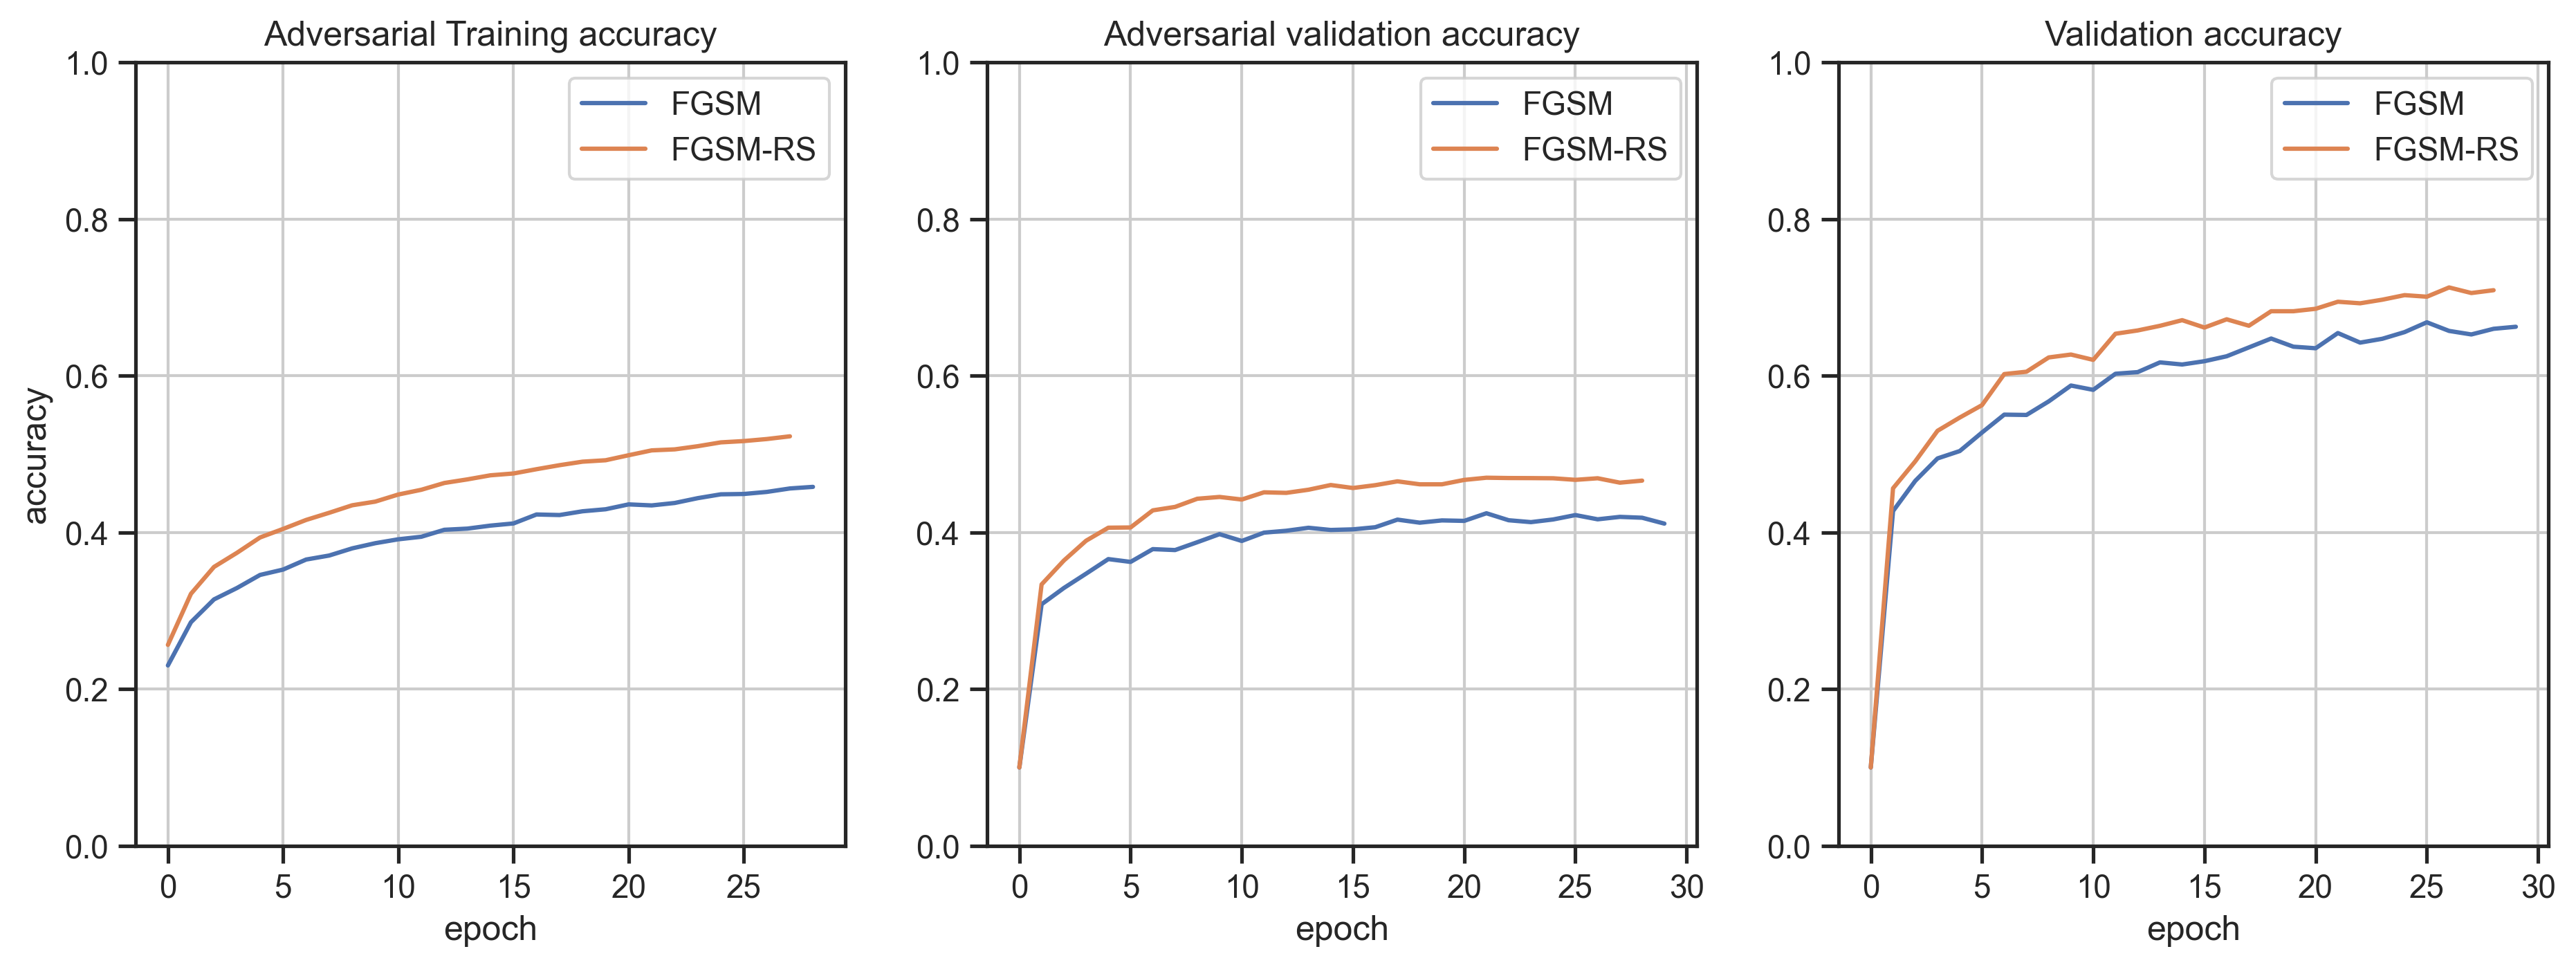

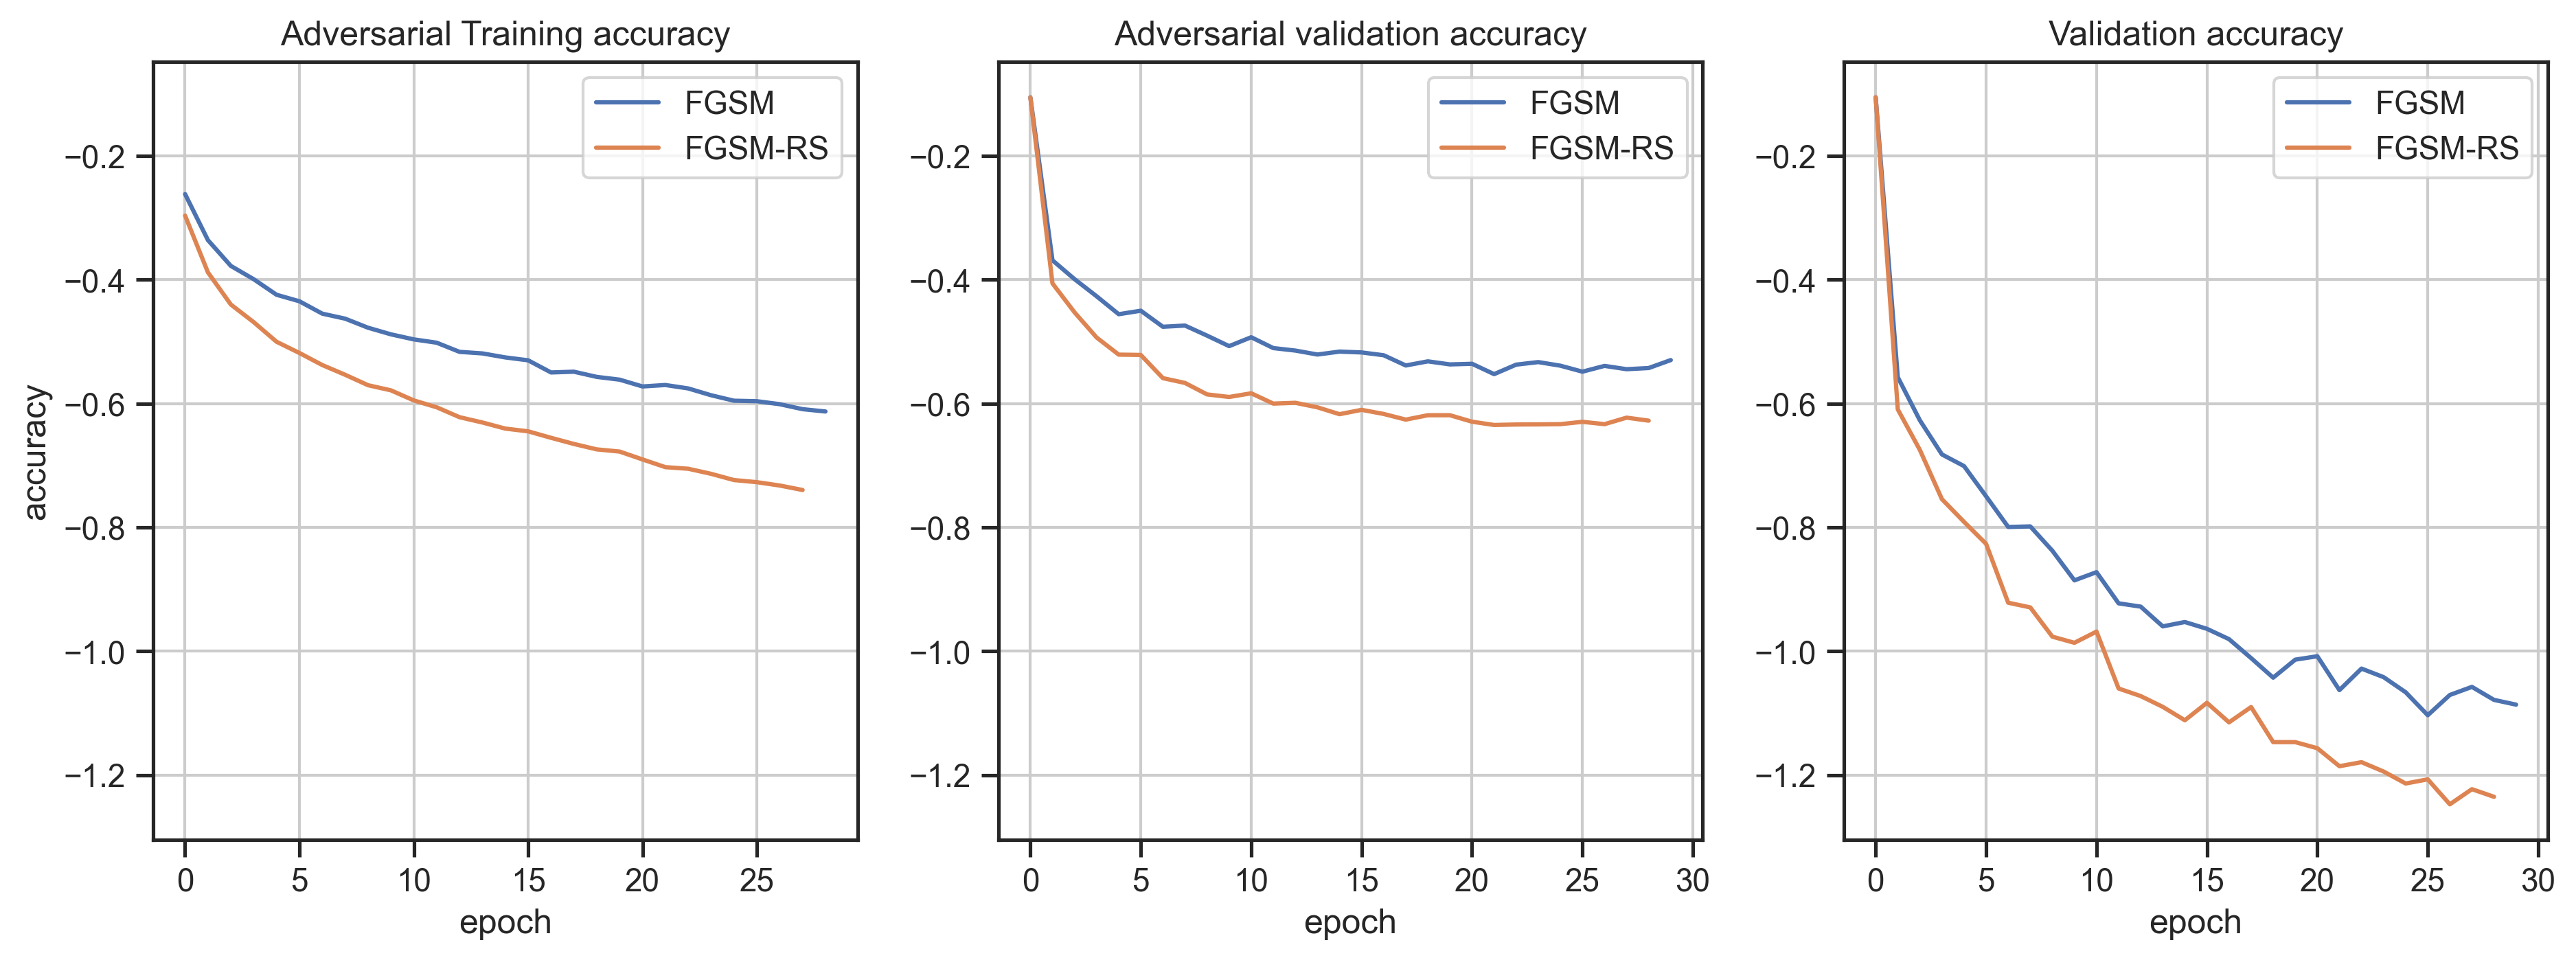

In [60]:
test_ = plot_attack_type(df, "FGSM", save_to_file)
test_ = plot_attack_type_log_acc(df, "FGSM", save_to_file)

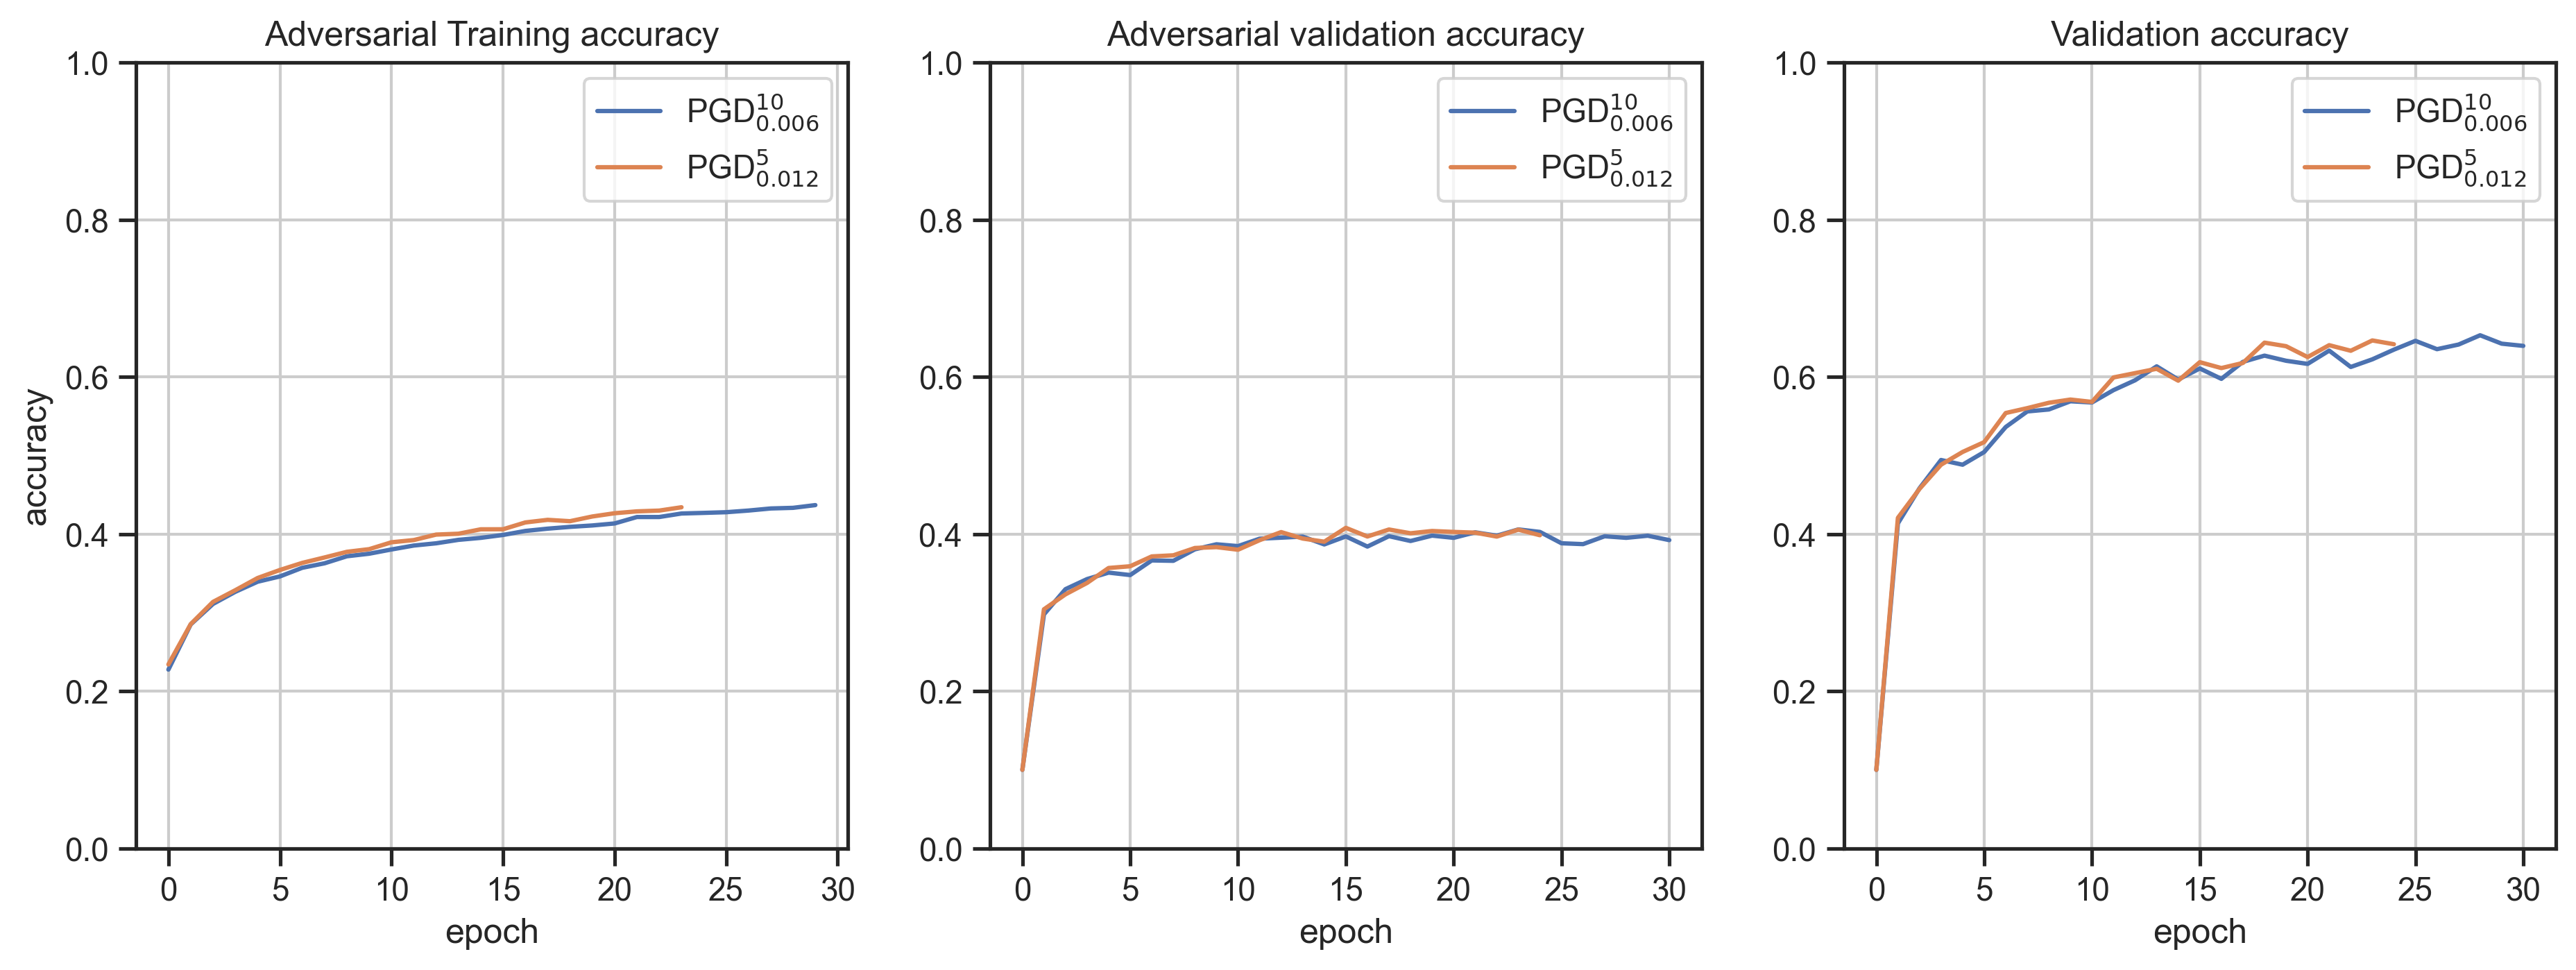

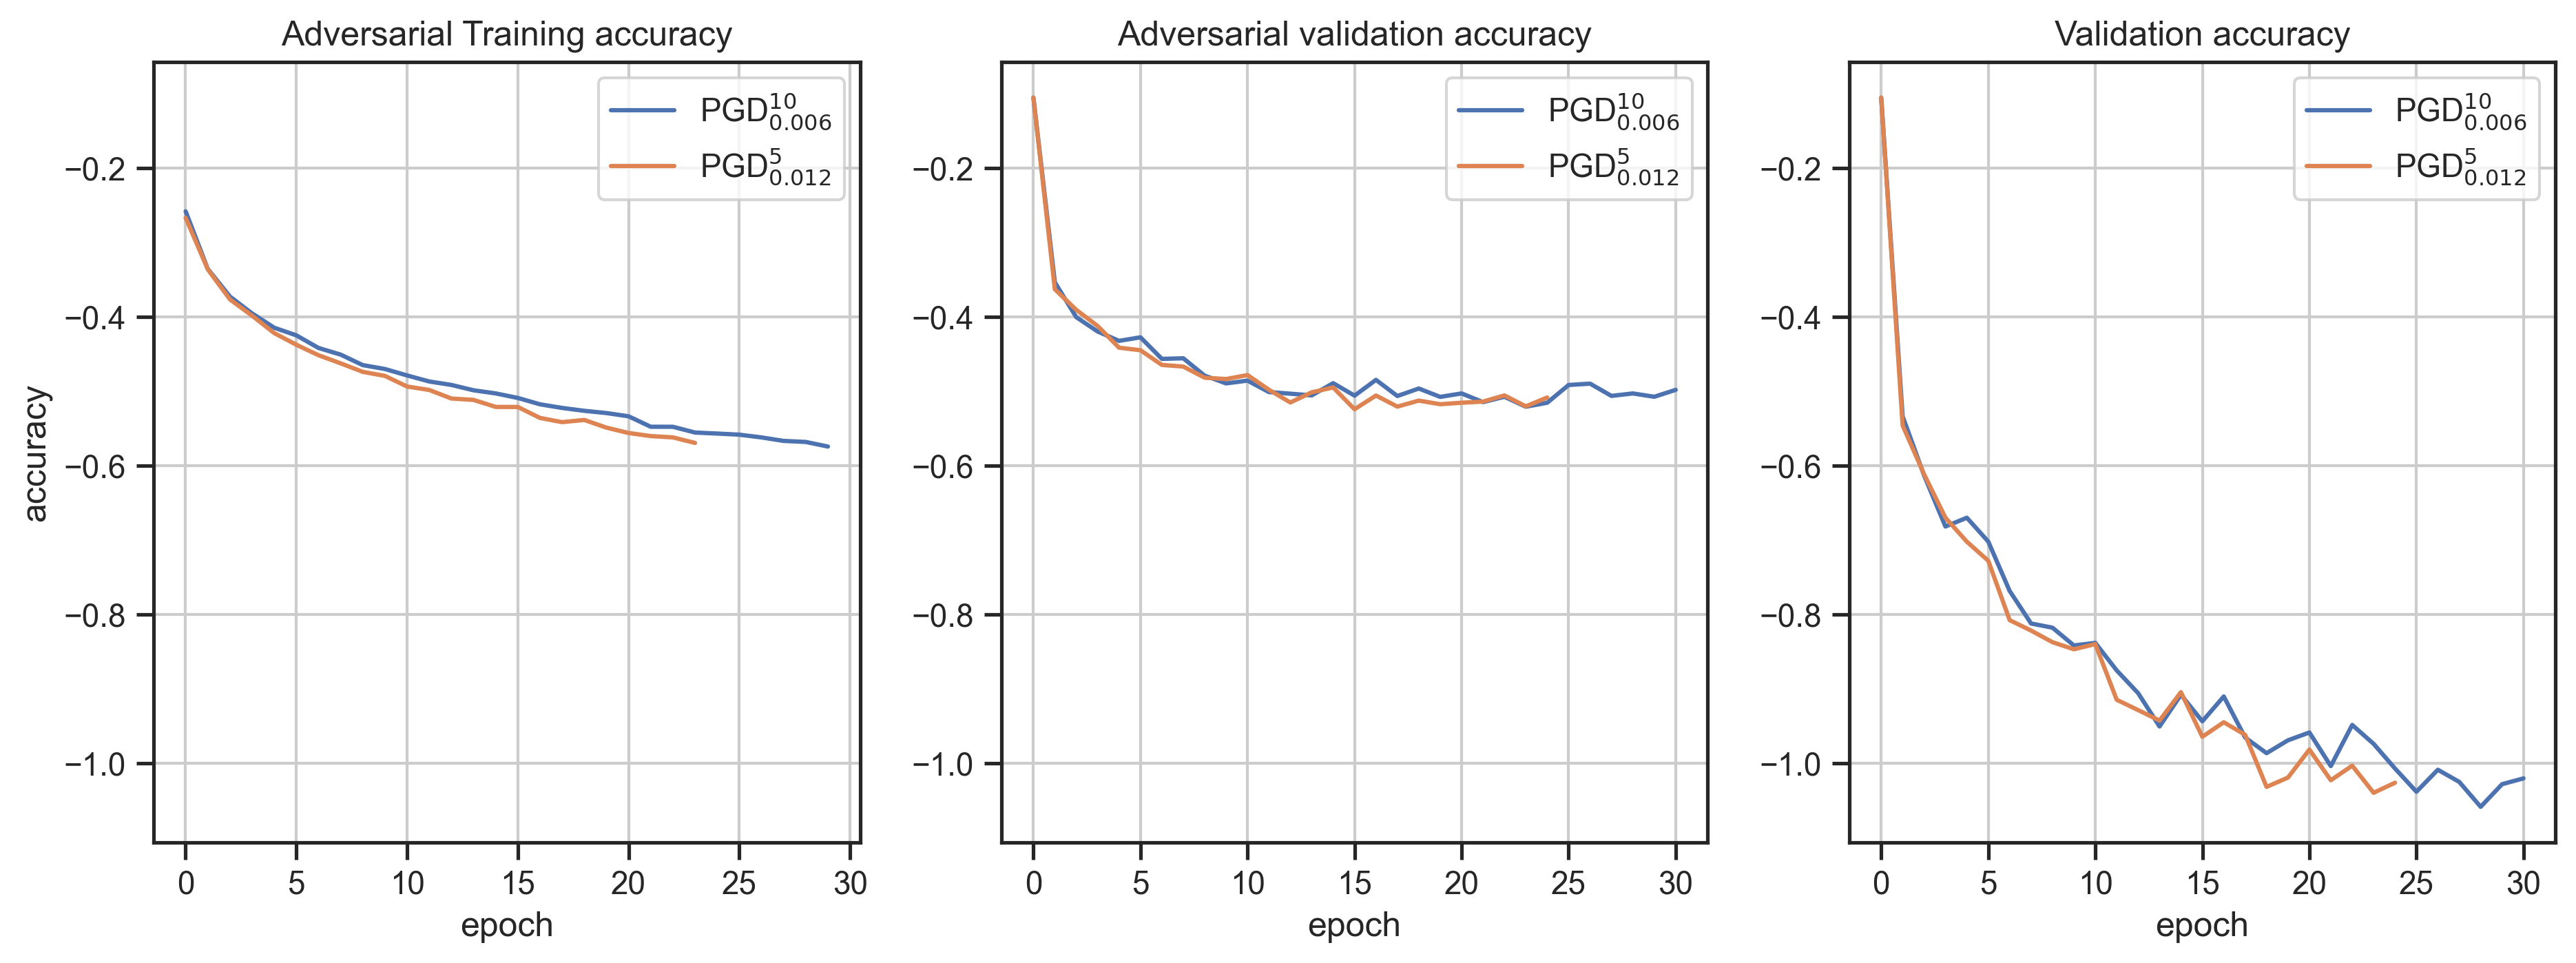

In [61]:
plot_attack_type(df, "PGD", save_to_file)
plot_attack_type_log_acc(df, "PGD", save_to_file)



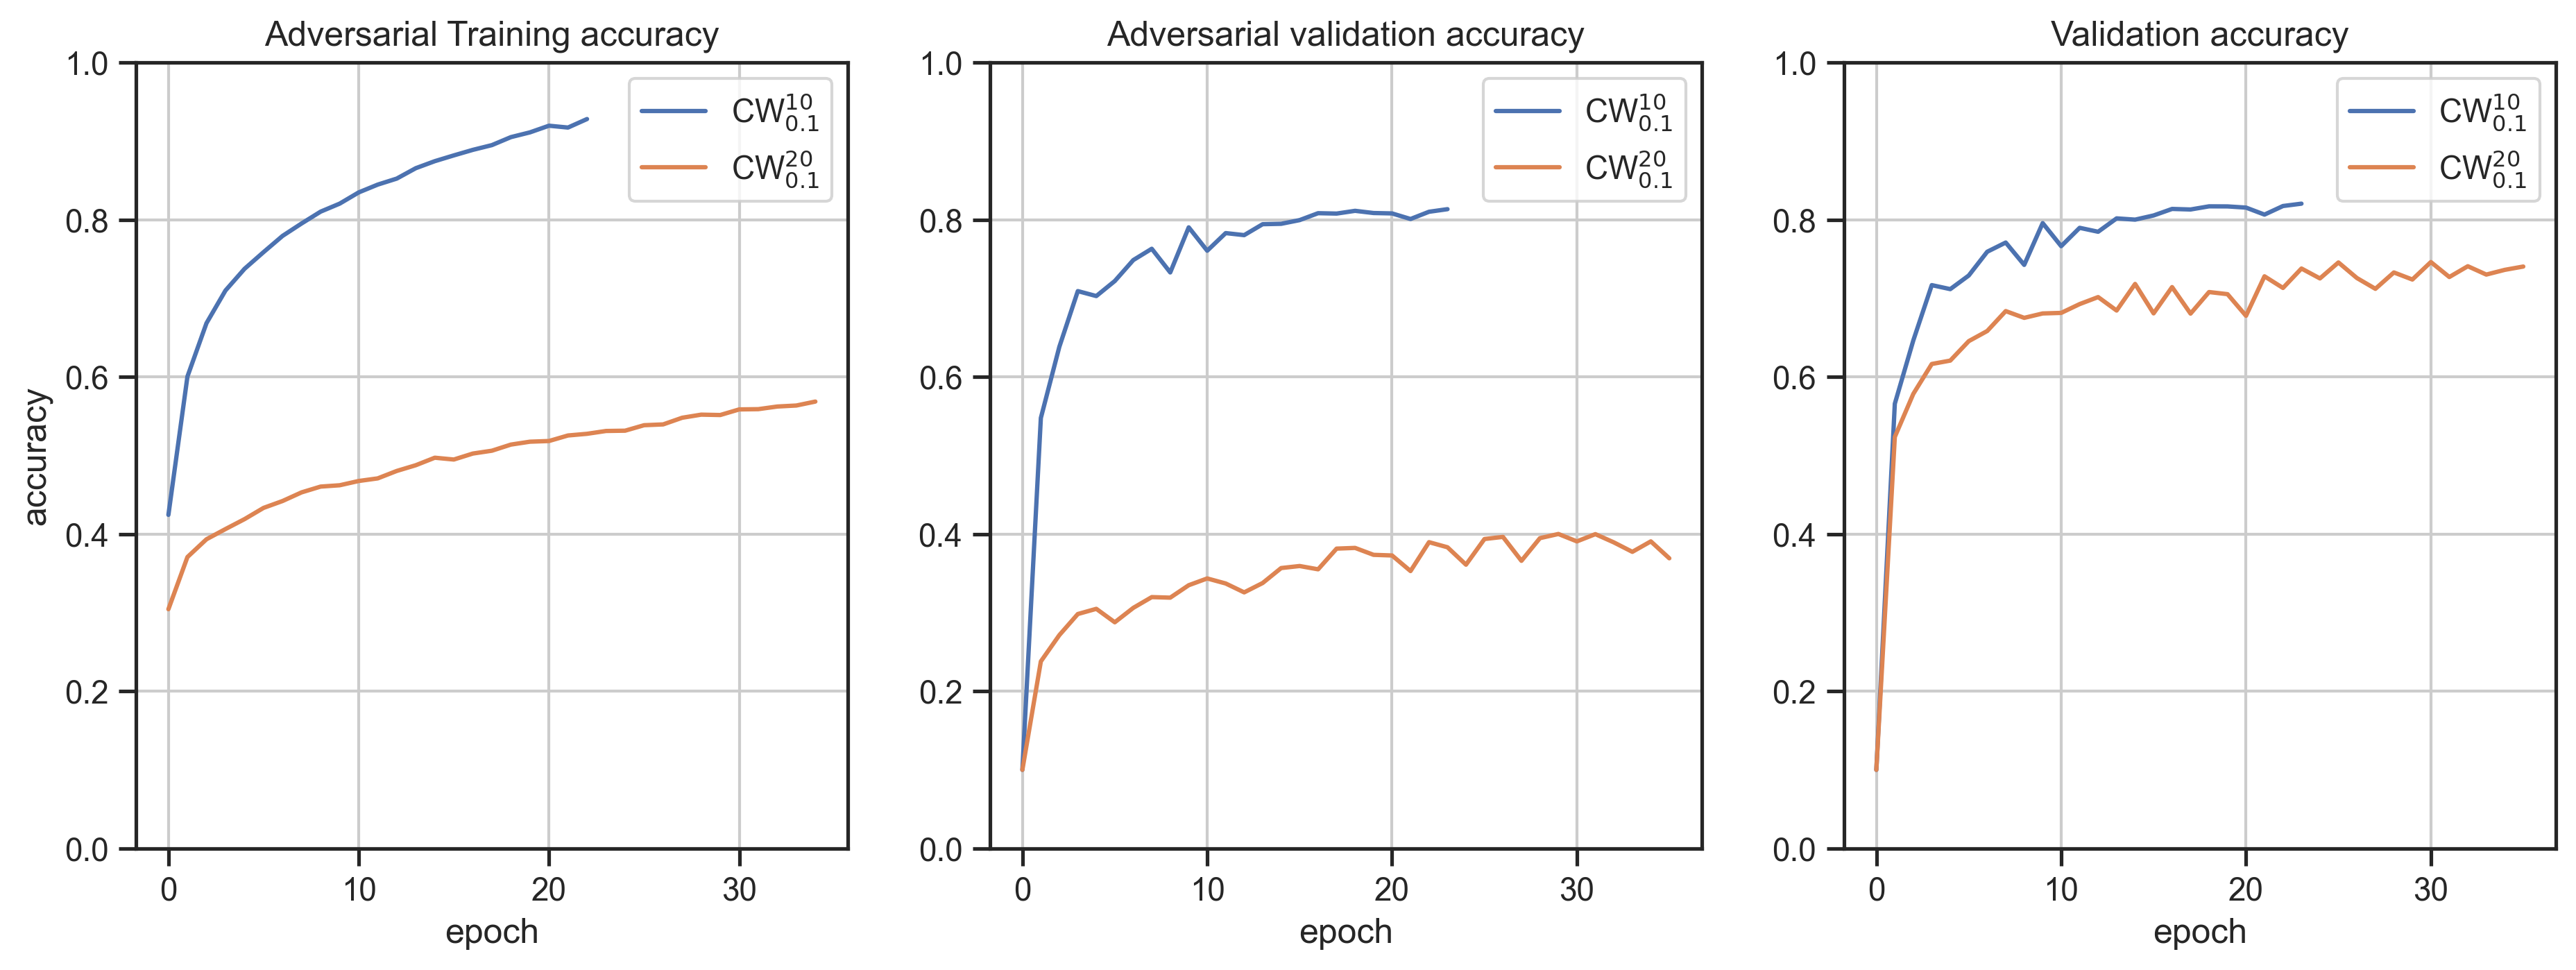

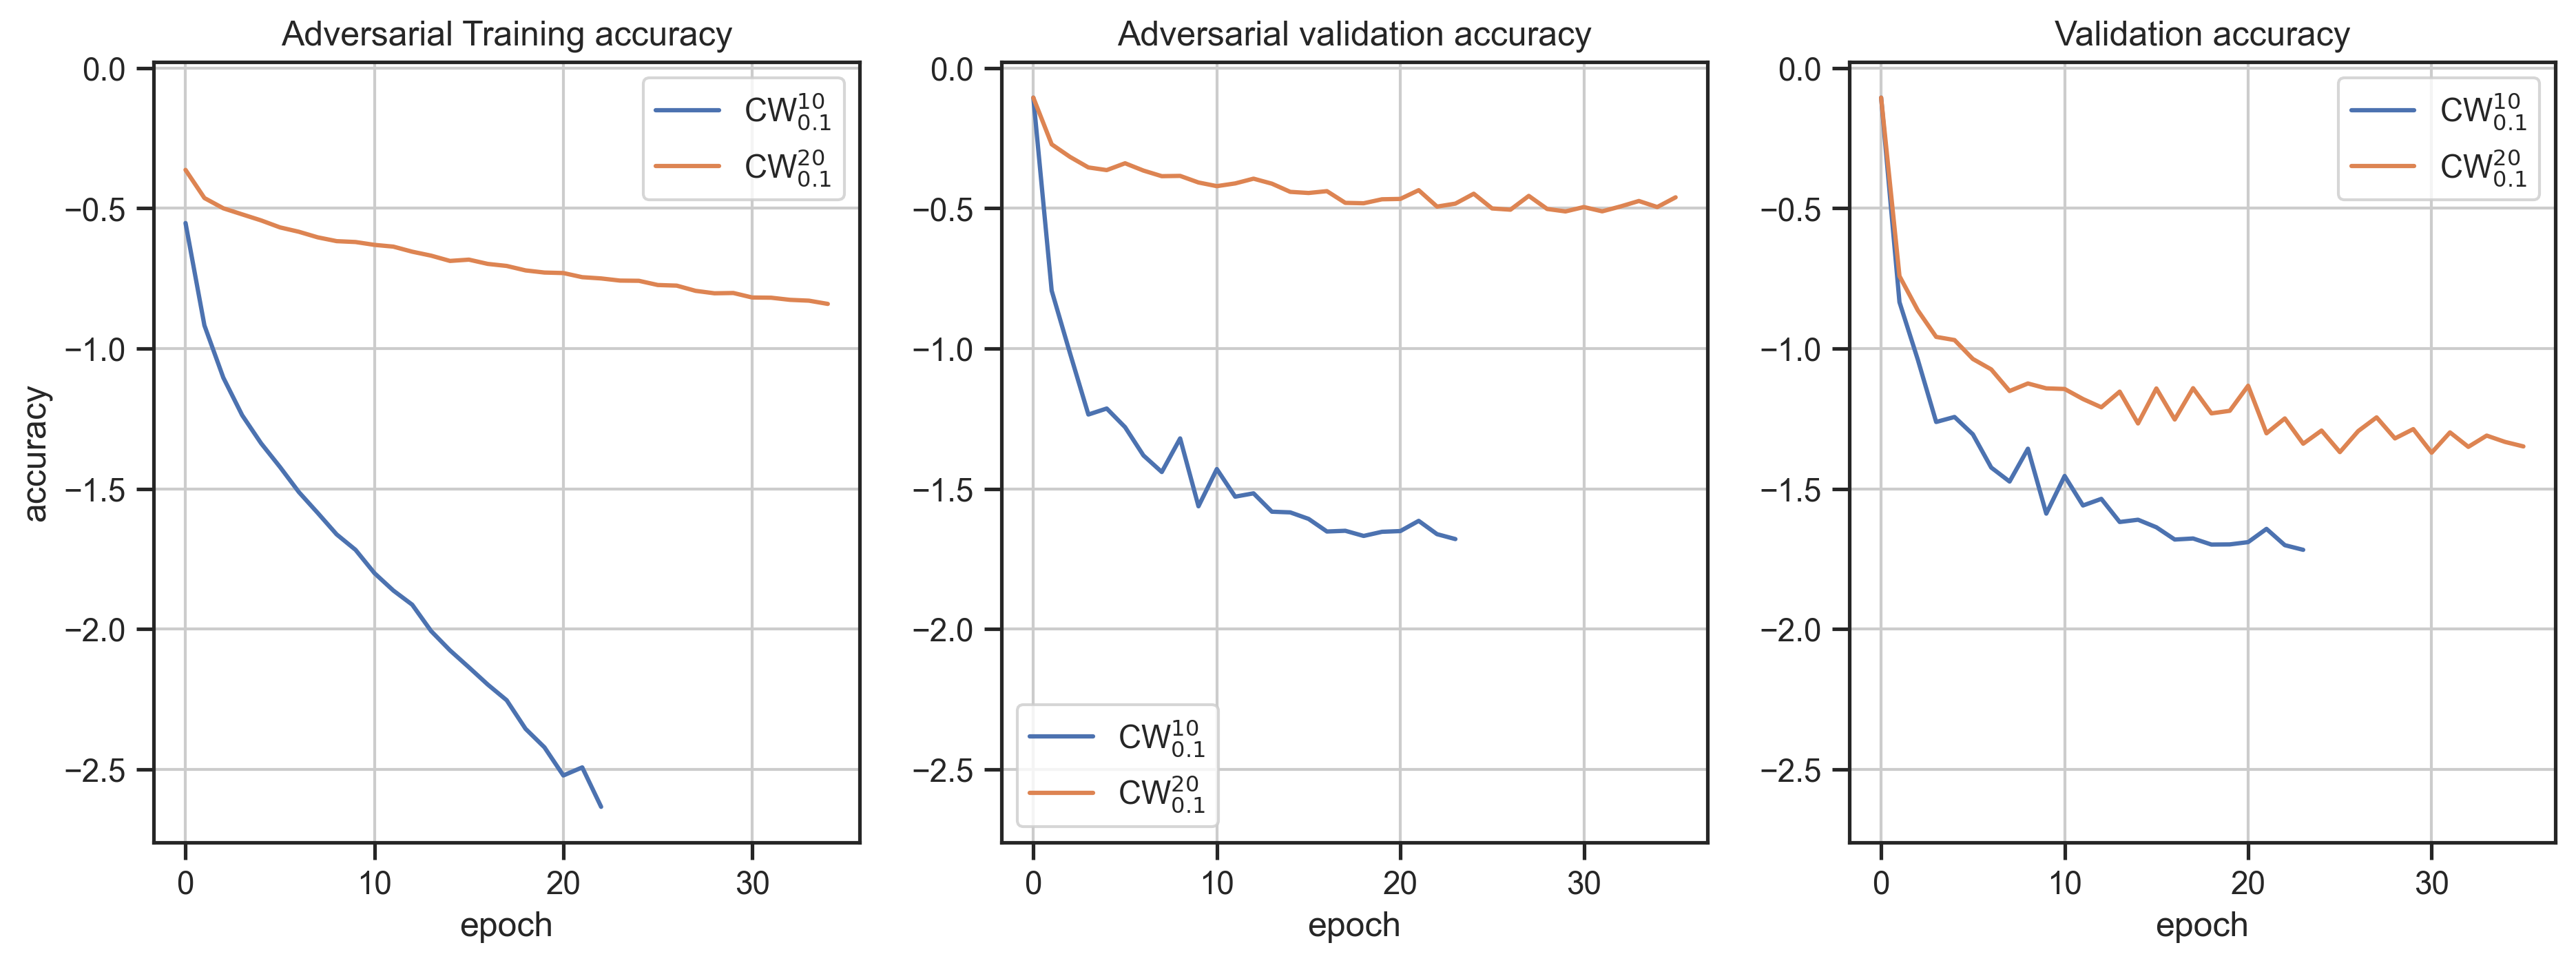

In [62]:
plot_attack_type(df, "CW", save_to_file)
plot_attack_type_log_acc(df, "CW", save_to_file)


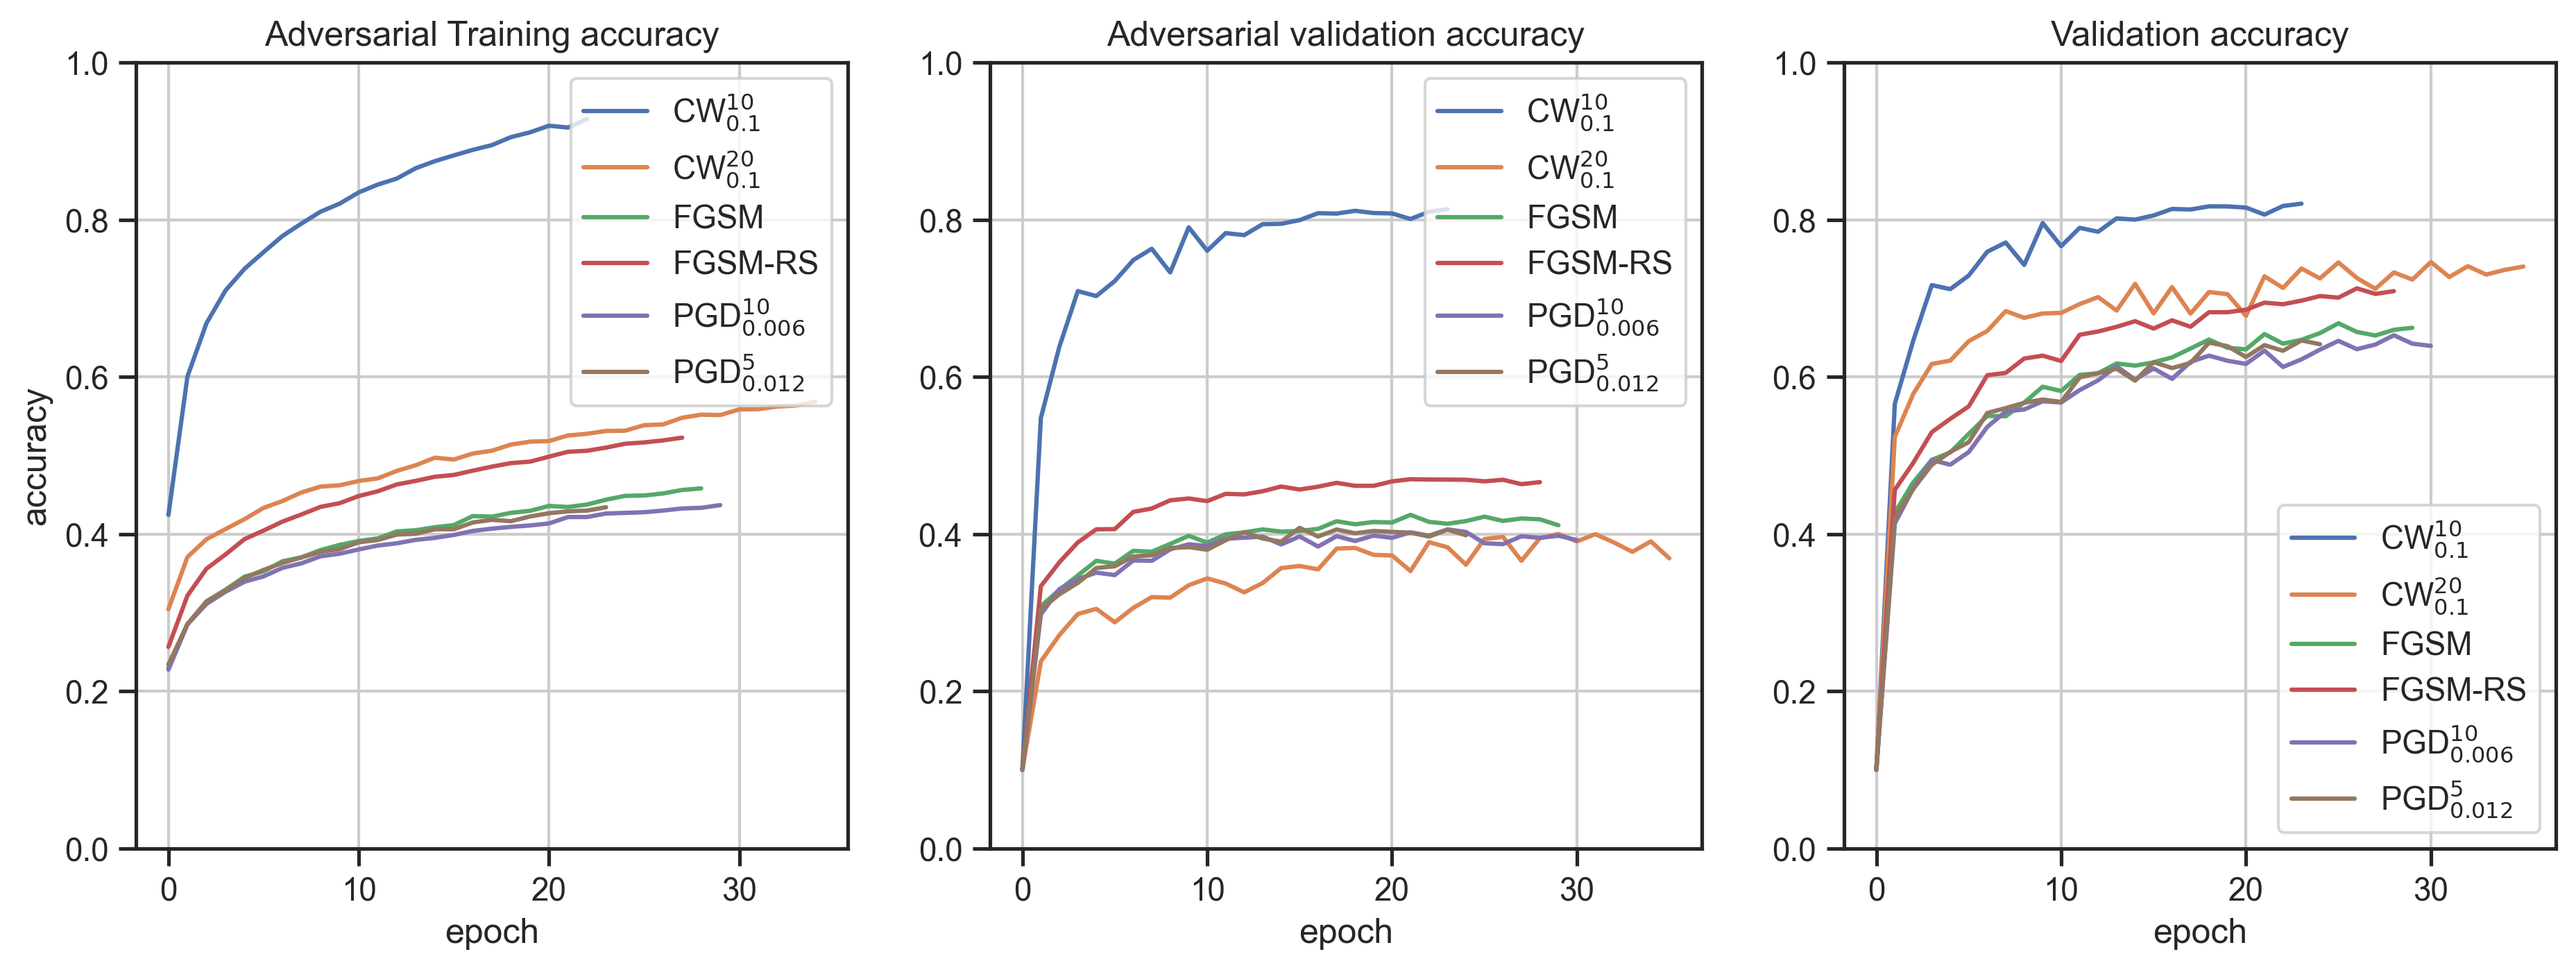

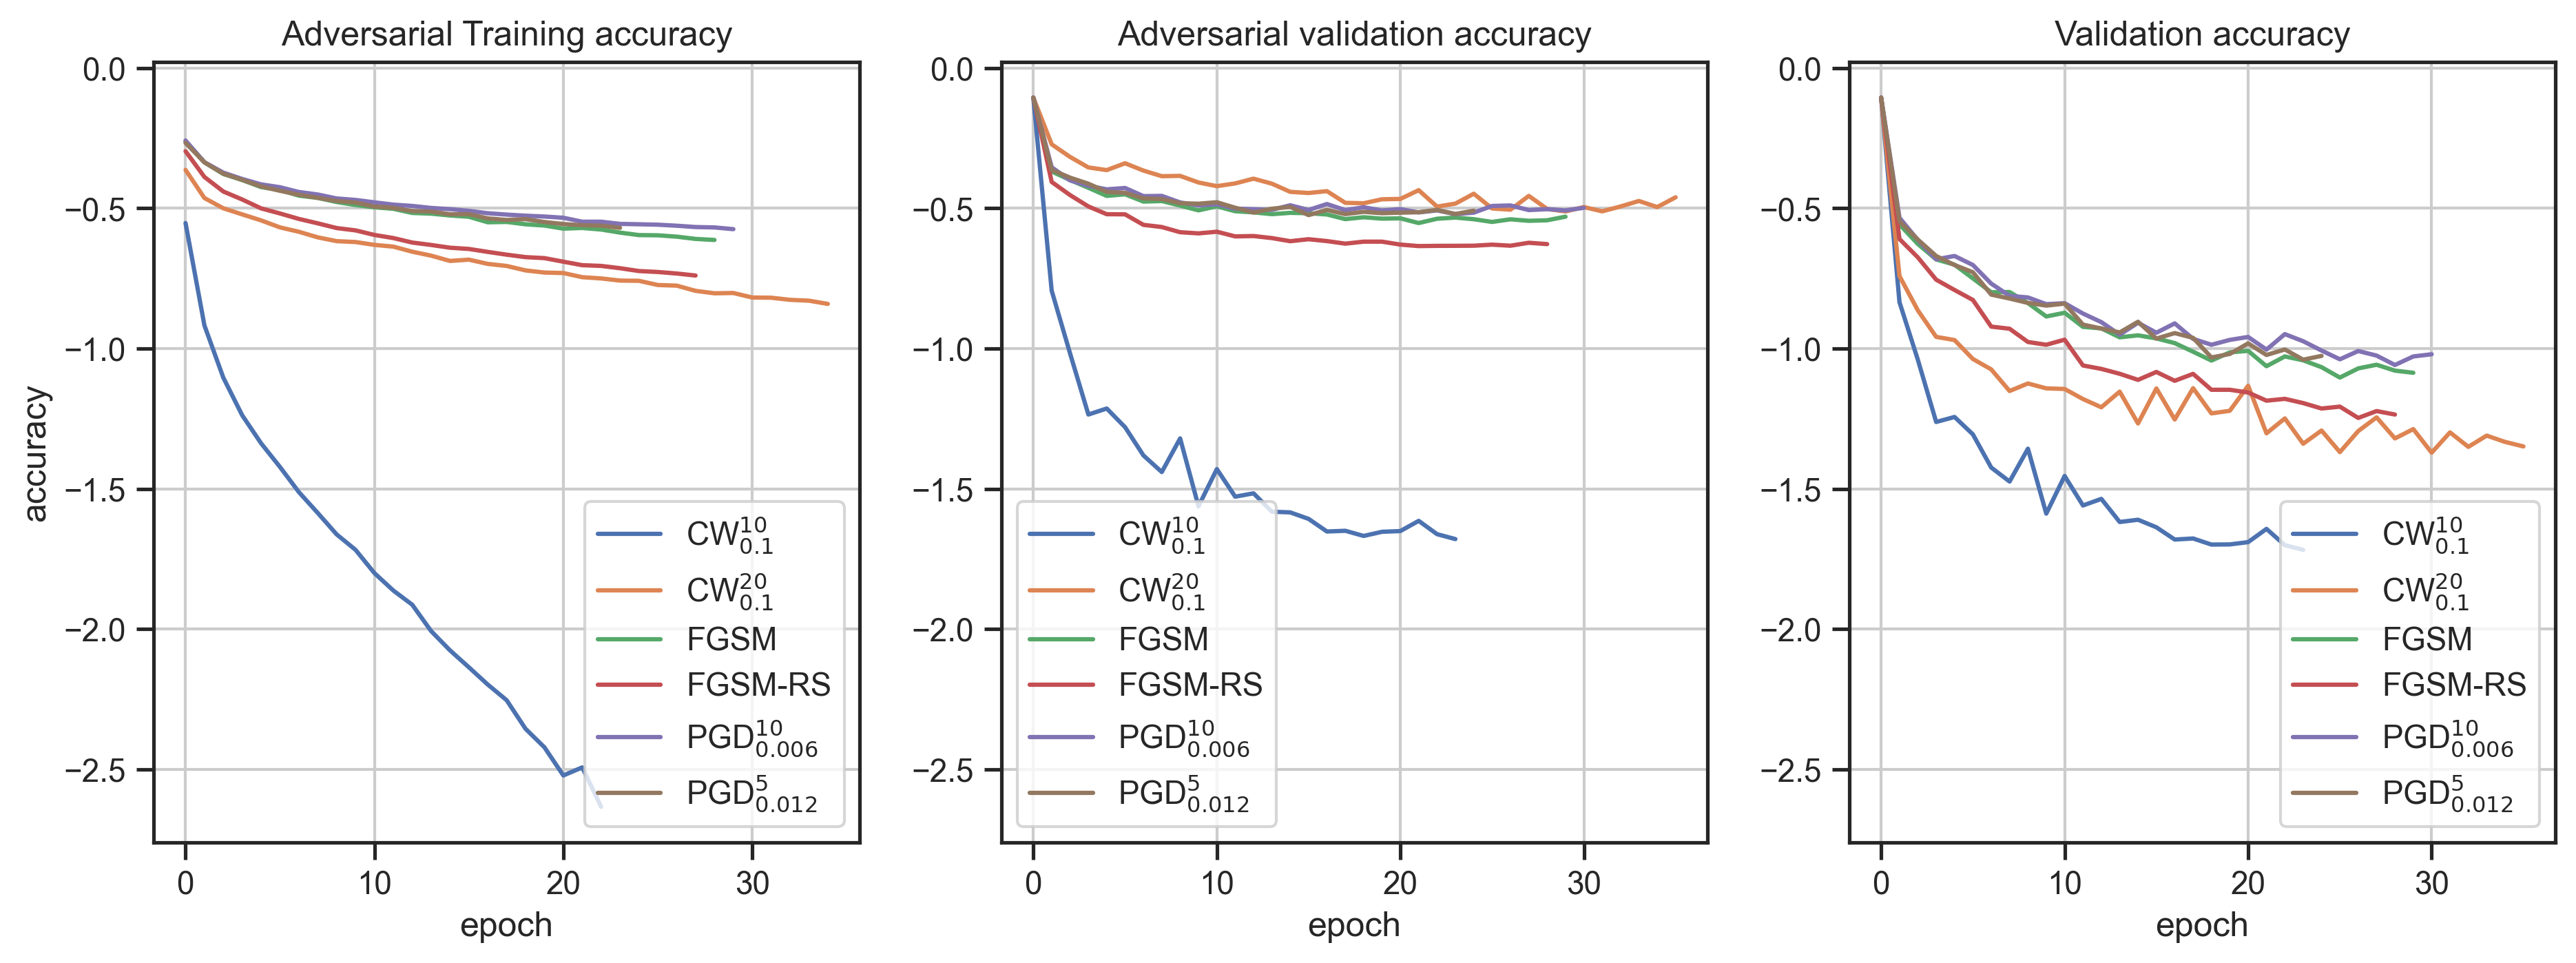

In [63]:
plot_attack_type(df, "-")
plot_attack_type_log_acc(df, "-")
